In [3]:
from keras import Model
from keras.initializers import RandomNormal, Zeros
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Dropout, Add, Conv2DTranspose, \
    LeakyReLU, Concatenate

from keras.optimizers import Adam


import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from PIL import Image
import numpy as np

Using TensorFlow backend.


In [4]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D,Concatenate, Cropping2D, ZeroPadding2D
import tensorflow as tf
import random
import keras
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from IPython.display import clear_output
from IPython.display import Image
seed = 2019
np.random.seed = seed
random.seed = seed
tf.seed = seed
path = '/home/karan/Desktop/Chandigarh_Police_Hackathon'


In [5]:
image_id_list = os.listdir(path+'/jpg')

In [72]:
image_size = (128,128)
train_path = '/home/karan/Desktop/Chandigarh_Police_Hackathon'
epochs = 30
validation_size = 16

In [33]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,ids,filepath,batch_size=16,image_size=(512,256),channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
            return (len(self.ids)//self.batch_size)
        
    '''def __load__(self,id_name):
            img = cv2.imread(filepath+'/'+id_name,-1)
            img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
            return img'''
            
            
            
    def __getitem__(self,index):
            indexes = range(index*self.batch_size,index*self.batch_size+self.batch_size)
            
            ids_to_load = [self.ids[k] for k in indexes]
            X = self.__generate_x(ids_to_load)
            y = self.__generate_y(ids_to_load)
            l = []
            for i,m in enumerate(X):
                l.append(m.reshape(128,128,3))
            X = np.array(l)
            l = []
            for i,m in enumerate(y):
                l.append(m.reshape(128,128,3))
            y = np.array(l)
            return X,y
            
        
        
    def __generate_x(self,id_names):
            X = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                #print(self.filepath+'/sketch/'+id_n+'-sz1.jpg')
                img = cv2.imread(self.filepath+'/sketch_jpg/'+id_n)
                '''plt.imshow(img)
                plt.show()'''
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                
                img = img.astype(np.float32)/255.
                
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                X[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return X
        
    def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath+'/jpg/'+id_n)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                y[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return y
             
        
    ''' def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],4))
            
            for i,id_n in enumerate(id_names):
                im_name = self.train[self.train['image_id'] == id_n]
                rles = im_name['EncodedPixels'].values
                #print(rles,np.array(rles).shape)
                y[i,:,:,:] = build_masks(rles,(1400,2100),reshape=(self.image_size[0],self.image_size[1]))
            
            return y'''
        
        

In [34]:
train_gen = DataGenerator(image_id_list[:int(len(image_id_list)*0.8)],train_path,batch_size=2,image_size=image_size,channels=3)
val_gen = DataGenerator(image_id_list[int(len(image_id_list)*0.8):],train_path,batch_size=2,image_size=image_size,channels=3)

In [35]:
X,y = val_gen.__getitem__(1)
val_gen.__len__()

75

In [36]:
len(image_id_list)

751

In [37]:
X.shape

(2, 128, 128, 3)

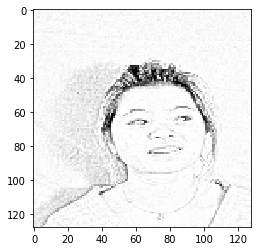

In [38]:
plt.imshow(X[0])
plt.show()

In [53]:


debug = False
image_source_dir = './dataset/facades/'
direction = 'b2a'
input_channel = 3  # input image channels
output_channel = 3  # output image channels
lr = 0.0002
epoch = 1
crop_from = 286
#image_size = (640,480)
batch_size = 2
combined_filepath = 'best_weights.h5'
generator_filepath = 'generator.h5'
seed = 9584
imagenet_mean = np.array([0.5, 0.5, 0.5])
imagenet_std = np.array([0.5, 0.5, 0.5])

In [54]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [55]:
def residual_block(feature, dropout=False):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return Add()([feature, x])

In [56]:
def conv_block(feature, out_channel, downsample=True, dropout=False):
    if downsample:
        x = Conv2D(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    else:
        x = Conv2DTranspose(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x


In [57]:
def get_generator(n_block=3):
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    x = Conv2D(64, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(n_block):
        x = residual_block(x)
    # upsample
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # upsample
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out
    x = Conv2D(output_channel, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

In [58]:
def get_generator_unet(n_block=3):
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    # encoder
    e0 = Conv2D(64, kernel_size=4, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    e0 = BatchNormalization()(e0)
    e0 = Activation('relu')(e0)
    e1 = conv_block(e0, 128, downsample=True, dropout=False)  # 1/2
    e2 = conv_block(e1, 256, downsample=True, dropout=False)  # 1/4
    e3 = conv_block(e2, 512, downsample=True, dropout=False)  # 1/8
    e4 = conv_block(e3, 512, downsample=True, dropout=False)  # 1/16
    e5 = conv_block(e4, 512, downsample=True, dropout=False)  # 1/32
    e6 = conv_block(e5, 512, downsample=True, dropout=False)  # 1/64
    e7 = conv_block(e6, 512, downsample=True, dropout=False)  # 1/128
    # decoder
    d0 = conv_block(e7, 512, downsample=False, dropout=True)  # 1/64
    d1 = Concatenate(axis=-1)([d0, e6])
    d1 = conv_block(d1, 512, downsample=False, dropout=True)
    '''ch, cw = get_crop_shape(e5,d1)
    d1 = ZeroPadding2D(padding = (ch,cw))(d1)# 1/32'''
    d2 = Concatenate(axis=-1)([d1, e5])
    d2 = conv_block(d2, 512, downsample=False, dropout=True)  # 1/16
    d3 = Concatenate(axis=-1)([d2, e4])
    d3 = conv_block(d3, 512, downsample=False, dropout=True)  # 1/8
    d4 = Concatenate(axis=-1)([d3, e3])
    d4 = conv_block(d4, 256, downsample=False, dropout=True)  # 1/4
    d5 = Concatenate(axis=-1)([d4, e2])
    d5 = conv_block(d5, 128, downsample=False, dropout=True)  # 1/2
    d6 = Concatenate(axis=-1)([d5, e1])
    d6 = conv_block(d6, 64, downsample=False, dropout=True)  # 1
    # out
    x = Conv2D(output_channel, kernel_size=3, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(d6)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

In [59]:
def get_generator_training_model(generator, discriminator):
    imgA = Input(shape=(image_size[0], image_size[1], input_channel))
    imgB = Input(shape=(image_size[0], image_size[1], input_channel))
    fakeB = generator(imgA)
    # discriminator.trainable=False
    realA_fakeB = Concatenate()([imgA, fakeB])
    pred_fake = discriminator(realA_fakeB)
    generator_training_model = Model(inputs=[imgA, imgB], outputs=[pred_fake, fakeB])
    return generator_training_model

In [60]:
def get_discriminator(n_layers=4, use_sigmoid=True):
    input = Input(shape=(image_size[0], image_size[1], input_channel + output_channel))
    x = Conv2D(64, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)
    x = LeakyReLU(alpha=0.2)(x)
    for i in range(1, n_layers):
        x = Conv2D(64 * 2 ** i, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64 * 2 ** n_layers, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)
    discriminator = Model(inputs=input, outputs=x)
    return discriminator

In [61]:
train_step_per_epoch = int(len(image_id_list)*0.8) / batch_size + 1
test_step_per_epoch = int(len(image_id_list)*0.2) / batch_size + 1
train_image_generator =  DataGenerator(image_id_list[:int(len(image_id_list)*0.8)],train_path,batch_size=2,image_size=image_size,channels=3)

test_image_generator = DataGenerator(image_id_list[int(len(image_id_list)*0.8):],train_path,batch_size=2,image_size=image_size,channels=3)

In [64]:
opt1 = Adam(lr=lr)
opt2 = Adam(lr=lr)
discriminator = get_discriminator()
print(discriminator.summary())
generator = get_generator_unet()
generator.compile(optimizer=opt2, loss='mae', metrics=['mean_absolute_percentage_error'])
print(generator.summary())
generator_train = get_generator_training_model(generator, discriminator)
print(generator_train.summary())
if os.path.exists(combined_filepath):
    generator_train.load_weights(combined_filepath, by_name=True)
    generator.load_weights(generator_filepath, by_name=True)
    print('weights loaded!')
discriminator.compile(optimizer=opt1, loss='mse', metrics=['acc'], loss_weights=None, sample_weight_mode=None)
generator_train.compile(optimizer=opt2, loss=['mse', 'mae'],
                        metrics=['mean_absolute_percentage_error'],
                        loss_weights=[1, 10])
real = np.ones((batch_size, 8, 8, 1))
fake = np.zeros((batch_size, 8, 8, 1))
best_loss = 1000

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 64)        6208      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 256)       5245

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 128, 128, 3)  54427215    input_13[0][0]                   
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 128, 128, 6)  0           input_13[0][0]                   
                                                                 model_9[1][0]                    
__________________________________________________________________________________________________
model_8 (Model)                 (None, 8, 8, 1)      11173313    concatenate_22[0][0]      

In [ ]:
for i in range(epochs):
    train_step = 0
    for imgA, imgB in train_image_generator:
        train_step += 1
        if train_step > train_step_per_epoch:
            test_step = 0
            total_loss = 0
            total_mape = 0
            for imgA, imgB in test_image_generator:
                test_step += 1
                if test_step > test_step_per_epoch:
                    break
                gloss, mape = generator.test_on_batch(imgA, imgB)
                # print generator.metrics_names
                total_loss += gloss
                total_mape += mape
            #print('epoch:{} test loss g:{:.2} \n   test mape:{}'.format(i + 1, total_loss / (test_step - 1),
                                                                     #total_mape / (test_step - 1)))
            if total_loss / (test_step - 1) < best_loss:
                print('test loss improved from {} to {}'.format(best_loss, total_loss / (test_step - 1)))
                generator_train.save_weights(combined_filepath, overwrite=True)
                generator.save_weights(generator_filepath, overwrite=True)
                best_loss = total_loss / (test_step - 1)
            break
        discriminator.trainable = True
        fakeB = generator.predict(imgA.reshape(2,*image_size,3))
        if debug:
            fakeb = (fakeB[0] + 1) * 127.5
            fakeb = np.clip(fakeb, 0, 255)
            fakeb = fakeb.astype(np.uint8)
            #fakeb = Image.fromarray(fakeb)
            #fakeb.save('predict/' + str(i + 1) + '_' + str(train_step) + '.png')
            print("{} saved".format('predict/' + str(i + 1) + '_' + str(train_step) + '.png'))
            imgb = (imgB[0] + 1) * 127.5
            imgb = np.clip(imgb, 0, 255)
            imgb = imgb.astype(np.uint8)
            #imgb = Image.fromarray(imgb)
            #imgb.save('predict/' + str(i + 1) + '_' + str(train_step) + '_real.png')
            print("{} saved".format('predict/' + str(i + 1) + '_' + str(train_step) + '_real.png'))
            # print('realB:', imgB[0], imgB.shape)
            # print descriminator.trainable
            # print descriminator.summary()
            d_fake = discriminator.predict(np.concatenate((imgA, fakeB), axis=-1))
            d_real = discriminator.predict(np.concatenate((imgA, imgB), axis=-1))
            # print('d_real:', np.squeeze(d_real[0]), d_real.shape)
            # print('d_fake:', np.squeeze(d_fake[0]), d_fake.shape)
        loss_fake, fake_acc = discriminator.train_on_batch(np.concatenate((imgA, fakeB), axis=-1), fake)
        loss_real, real_acc = discriminator.train_on_batch(np.concatenate((imgA, imgB), axis=-1), real)
        if train_step%20 == 0:
            print('epoch:{} train step:{}, loss d_fake:{:.2}, loss d_real:{:.2}, fake_acc:{:.2}, real_acc:{:.2}'.format(i + 1, train_step,loss_fake,loss_real,fake_acc,real_acc))
        # print descriminator.metrics_names
        discriminator.trainable = False
        # print generator_train.summary()
        loss = generator_train.train_on_batch([imgA, imgB], [real, imgB])
        # print generator_train.metrics_names
        # print descriminator.trainable
        if train_step%20 == 0:
            print('epoch:{} train step:{} loss fool:{:.2} loss g:{:.2}'.format(i + 1, train_step, loss[1], loss[0] - loss[1]))

epoch:1 train step:20, loss d_fake:6.3e-06, loss d_real:7.7e-06, fake_acc:1.0, real_acc:1.0
epoch:1 train step:20 loss fool:7.6e-07 loss g:2.8
epoch:1 train step:40, loss d_fake:9.1e-06, loss d_real:1.3e-06, fake_acc:1.0, real_acc:1.0
epoch:1 train step:40 loss fool:6.3e-06 loss g:2.9
epoch:1 train step:60, loss d_fake:0.73, loss d_real:0.0022, fake_acc:0.2, real_acc:1.0
epoch:1 train step:60 loss fool:0.32 loss g:4.1
epoch:1 train step:80, loss d_fake:0.95, loss d_real:0.0049, fake_acc:0.023, real_acc:0.99
epoch:1 train step:80 loss fool:0.02 loss g:1.4
epoch:1 train step:100, loss d_fake:0.82, loss d_real:0.049, fake_acc:0.15, real_acc:0.91
epoch:1 train step:100 loss fool:0.021 loss g:3.6
epoch:1 train step:120, loss d_fake:0.89, loss d_real:0.047, fake_acc:0.047, real_acc:0.91
epoch:1 train step:120 loss fool:0.054 loss g:2.1
epoch:1 train step:140, loss d_fake:1.0, loss d_real:0.00071, fake_acc:0.0, real_acc:1.0
epoch:1 train step:140 loss fool:0.016 loss g:2.5
epoch:1 train step:

In [66]:
X,y = val_gen.__getitem__(7)

In [67]:
y_pred = generator.predict(X)

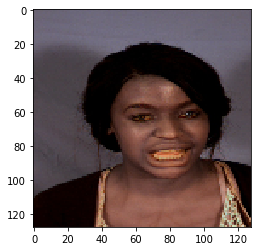

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


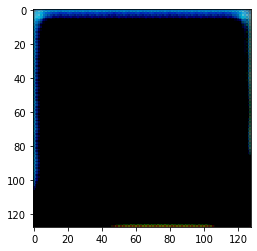

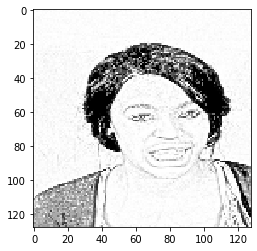

In [71]:
plt.imshow(y[0])
plt.show()
plt.imshow(y_pred[0])
plt.show()
plt.imshow(X[0])
plt.show()